# Introduction to neurospatial: The Basics

## Learning Objectives

By the end of this notebook, you will be able to:

- Understand what spatial discretization is and why it matters for neuroscience
- Create your first environment from position data
- Understand the concepts of bins, bin_size, and active bins
- Perform basic spatial queries: `bin_at()`, `contains()`, `neighbors()`
- Visualize environments using `plot()`
- Avoid common pitfalls when choosing bin_size

**Estimated time: 15-20 minutes**

## What is Spatial Discretization?

In neuroscience experiments, we often track an animal's position continuously through space. For example:
- A rat exploring an open field
- A mouse running on a linear track
- A human navigating a virtual environment

To analyze neural activity in relation to position, we need to **discretize** continuous space into distinct **bins** (also called spatial bins or nodes). Think of it like creating a grid overlay on your environment.

**Why discretize?**
- Compute spatial firing rate maps (place fields)
- Calculate occupancy-normalized neural activity
- Perform spatial statistics and decoding
- Identify regions of interest

The `neurospatial` library makes spatial discretization easy and flexible!

## Setup

First, let's import the necessary libraries:

In [18]:
import matplotlib.pyplot as plt
import numpy as np

from neurospatial import Environment

# Set random seed for reproducibility
np.random.seed(42)

# Configure matplotlib
plt.rcParams["figure.figsize"] = (10, 8)
plt.rcParams["font.size"] = 11

## Creating Synthetic Position Data

Let's simulate position data from an animal exploring a 100 cm × 100 cm open field. This represents what you might get from a tracking system like Optitrack, DeepLabCut, or similar.

In [19]:
# Simulate an animal's trajectory through a 100x100 cm open field
# We'll create a random walk with some drift to make it realistic

n_timepoints = 5000  # About 5 minutes at 20 Hz sampling
position_2d = np.zeros((n_timepoints, 2))
position_2d[0] = [50, 50]  # Start at center

# Random walk with drift toward center (animals tend to avoid edges)
for t in range(1, n_timepoints):
    # Random movement
    step = np.random.randn(2) * 2.0  # 2 cm standard deviation

    # Gentle drift toward center
    center_pull = (50 - position_2d[t - 1]) * 0.01

    # Update position
    position_2d[t] = position_2d[t - 1] + step + center_pull

    # Enforce boundaries (bounce off walls)
    position_2d[t] = np.clip(position_2d[t], 5, 95)

print(f"Generated {n_timepoints} position samples")
print(f"Position data shape: {position_2d.shape}")
print(f"X range: [{position_2d[:, 0].min():.1f}, {position_2d[:, 0].max():.1f}] cm")
print(f"Y range: [{position_2d[:, 1].min():.1f}, {position_2d[:, 1].max():.1f}] cm")

Generated 5000 position samples
Position data shape: (5000, 2)
X range: [10.4, 95.0] cm
Y range: [5.4, 90.0] cm


Let's visualize the trajectory:

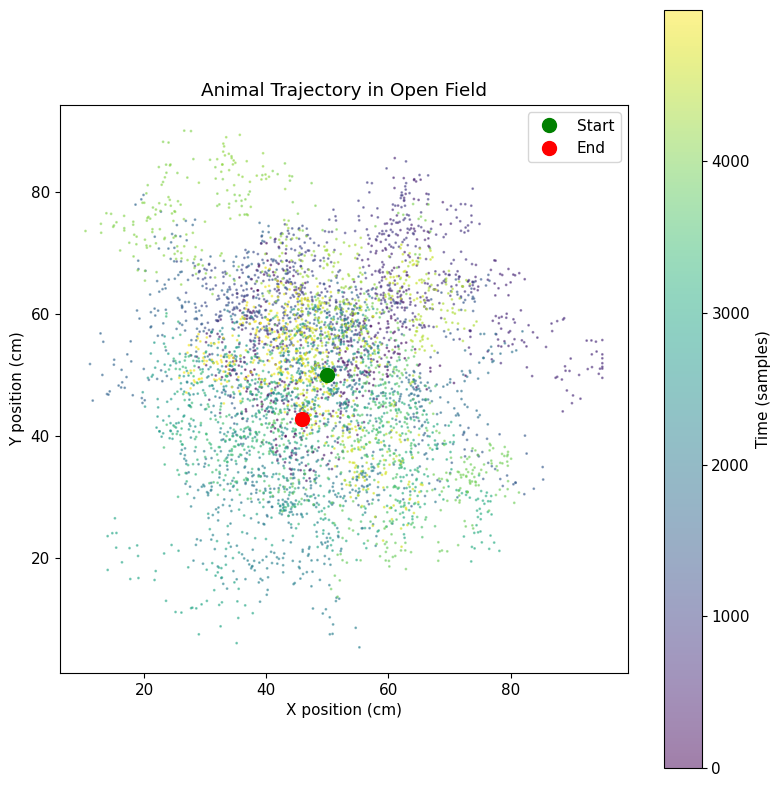

In [20]:
fig, ax = plt.subplots(figsize=(8, 8))

# Plot trajectory (color by time)
scatter = ax.scatter(
    position_2d[:, 0],
    position_2d[:, 1],
    c=np.arange(n_timepoints),
    cmap="viridis",
    s=1,
    alpha=0.5,
)

# Mark start and end
ax.plot(position_2d[0, 0], position_2d[0, 1], "go", markersize=10, label="Start")
ax.plot(position_2d[-1, 0], position_2d[-1, 1], "ro", markersize=10, label="End")

ax.set_xlabel("X position (cm)")
ax.set_ylabel("Y position (cm)")
ax.set_title("Animal Trajectory in Open Field")
ax.set_aspect("equal")
ax.legend()
plt.colorbar(scatter, ax=ax, label="Time (samples)")
plt.tight_layout()
plt.show()

## Creating Your First Environment

Now let's discretize this continuous trajectory into bins! The most common way to create an environment is using `Environment.from_samples()`, which automatically infers the spatial extent from your data.

**Key parameter: `bin_size`**
- This controls how finely we divide up space
- Units match your data (here: centimeters)
- Typical values: 2-5 cm for rodent experiments
- Trade-off: smaller bins = more spatial resolution, but fewer samples per bin

In [21]:
# Create environment with 5 cm bins
env = Environment.from_samples(
    data_samples=position_2d,
    bin_size=5.0,  # 5 cm bins
    name="OpenFieldExample",
)

print(env.info())

Environment Information

Name: OpenFieldExample
Layout Type: RegularGrid
Dimensions: 2
Number of Bins: 211

Spatial Extent:
  Dimension 0: [7.91, 97.50] (range: 89.59)
  Dimension 1: [2.94, 92.50] (range: 89.57)

Bin Sizes:
  Dimension 0: 4.98
  Dimension 1: 4.98

Regions: None



Let's break down what we see in the info output:

- **Name**: The label we gave our environment
- **Layout type**: `RegularGrid` (the default grid-based discretization)
- **Dimensions**: 2D (x and y coordinates)
- **Total bins**: The maximum possible number of bins (grid size)
- **Active bins**: Bins that contain data samples
- **Dimension ranges**: The spatial extent in each dimension

## Understanding Active vs Inactive Bins

By default, `from_samples()` infers which bins are "active" based on whether they contain data. This is important for:
- Ignoring walls and obstacles
- Focusing analysis on visited areas
- Avoiding division by zero in occupancy normalization

Let's explore the environment properties:

In [22]:
# Environment properties
print(f"Number of bins: {env.n_bins}")
print(f"Number of dimensions: {env.n_dims}")
print(f"Grid shape: {env.grid_shape}")
print(f"Bin centers shape: {env.bin_centers.shape}")
print("\nDimension ranges:")
for dim, (min_val, max_val) in enumerate(env.dimension_ranges):
    print(f"  Dim {dim}: [{min_val:.1f}, {max_val:.1f}] cm")

Number of bins: 211
Number of dimensions: 2
Grid shape: (18, 18)
Bin centers shape: (211, 2)

Dimension ranges:
  Dim 0: [7.9, 97.5] cm
  Dim 1: [2.9, 92.5] cm


## Visualizing the Environment

The `plot()` method gives us a quick visualization of our discretized environment:

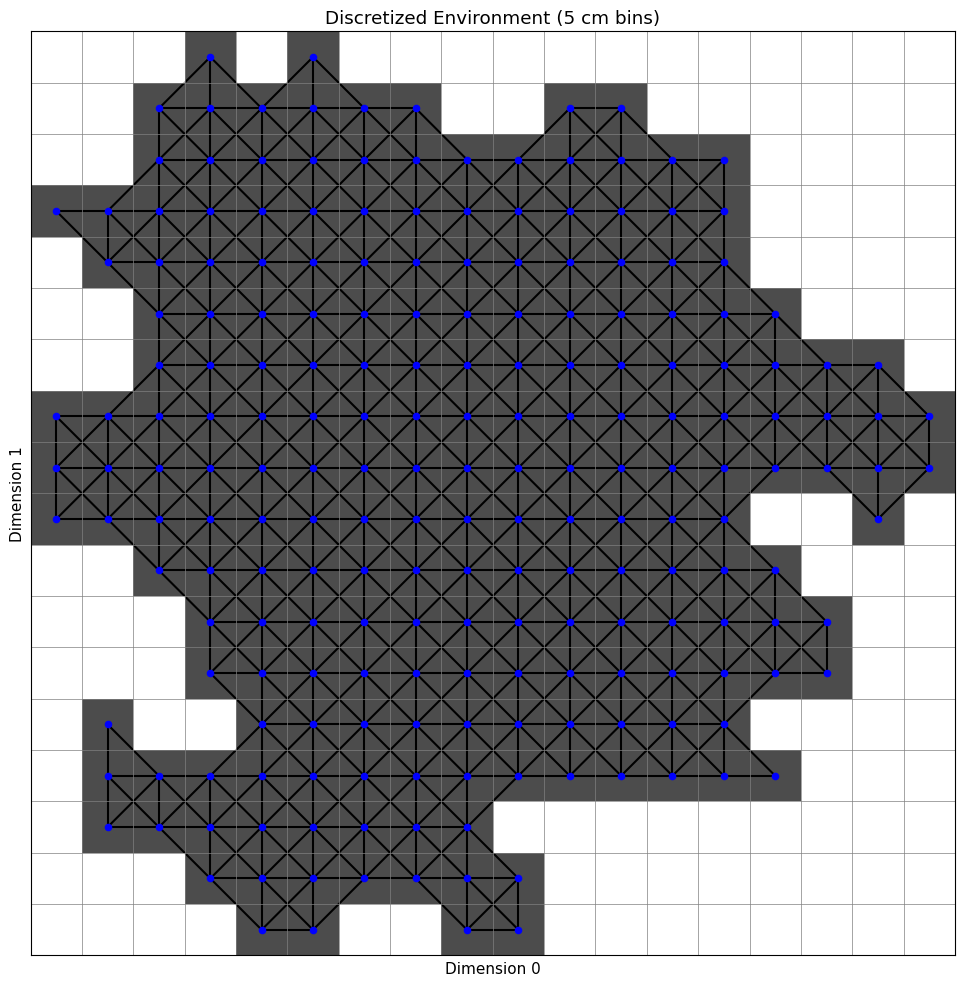

In [23]:
fig, ax = plt.subplots(figsize=(10, 10))
env.plot(ax=ax, show_connectivity=True)
ax.set_title("Discretized Environment (5 cm bins)")
plt.tight_layout()
plt.show()

**What you're seeing:**
- Blue dots: Active bin centers (areas the animal visited)
- Gray lines: Connectivity between neighboring bins
- The grid structure with 5 cm spacing

## Basic Spatial Queries

Now let's explore the core operations you'll use for spatial analysis.

### 1. Mapping Points to Bins: `bin_at()`

This is probably the most common operation—mapping continuous positions to discrete bin indices:

In [24]:
# Map all position samples to bin indices
bin_indices = env.bin_at(position_2d)

print(f"Bin indices shape: {bin_indices.shape}")
print(f"Example: position {position_2d[0]} -> bin {bin_indices[0]}")
print(f"\nUnique bins visited: {len(np.unique(bin_indices[bin_indices >= 0]))}")
print(f"Samples outside active bins: {np.sum(bin_indices < 0)}")

Bin indices shape: (5000,)
Example: position [50. 50.] -> bin 116

Unique bins visited: 211
Samples outside active bins: 0


**Important:** `bin_at()` returns `-1` for points outside active bins or environment bounds.

### 2. Computing Occupancy

Let's use bin indices to compute how much time was spent in each bin:

In [25]:
# Count samples per bin (occupancy)
occupancy = np.bincount(bin_indices[bin_indices >= 0], minlength=env.n_bins)

print(f"Occupancy array shape: {occupancy.shape}")
print(f"Total samples: {occupancy.sum()}")
print(f"Mean samples per active bin: {occupancy[occupancy > 0].mean():.1f}")
print(f"Max samples in any bin: {occupancy.max()}")

Occupancy array shape: (211,)
Total samples: 5000
Mean samples per active bin: 23.7
Max samples in any bin: 108


Let's visualize the occupancy map:

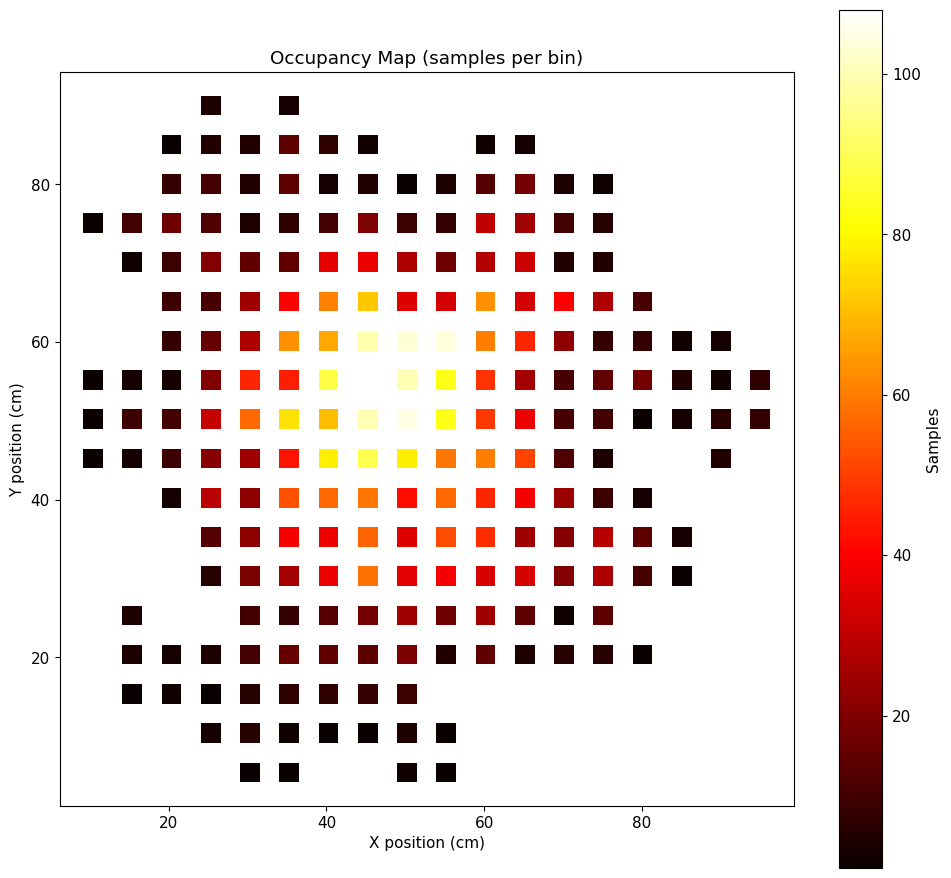

In [26]:
fig, ax = plt.subplots(figsize=(10, 9))

# Create occupancy map
scatter = ax.scatter(
    env.bin_centers[:, 0],
    env.bin_centers[:, 1],
    c=occupancy,
    s=200,
    cmap="hot",
    marker="s",  # Square markers
    edgecolors="none",
)

ax.set_xlabel("X position (cm)")
ax.set_ylabel("Y position (cm)")
ax.set_title("Occupancy Map (samples per bin)")
ax.set_aspect("equal")
plt.colorbar(scatter, ax=ax, label="Samples")
plt.tight_layout()
plt.show()

### 3. Checking if Points are in Environment: `contains()`

Sometimes you need to know if points are within the active environment:

In [27]:
# Test some points
test_points = np.array(
    [
        [50.0, 50.0],  # Center - should be in
        [10.0, 10.0],  # Corner - should be in
        [0.0, 0.0],  # Far corner - might be out
        [150.0, 50.0],  # Outside bounds - definitely out
    ]
)

is_contained = env.contains(test_points)

for point, contained in zip(test_points, is_contained, strict=False):
    status = "✓ IN" if contained else "✗ OUT"
    print(f"Point {point}: {status}")

Point [50. 50.]: ✓ IN
Point [10. 10.]: ✗ OUT
Point [0. 0.]: ✗ OUT
Point [150.  50.]: ✗ OUT


### 4. Finding Neighbors: `neighbors()`

The connectivity graph tells us which bins are adjacent to each other:

In [28]:
# Pick a bin near the center
center_point = np.array([[50.0, 50.0]])
center_bin = env.bin_at(center_point)[0]

# Find its neighbors
neighbor_bins = env.neighbors(center_bin)

print(f"Bin {center_bin} at position {env.bin_centers[center_bin]}")
print(f"has {len(neighbor_bins)} neighbors:")
for neighbor in neighbor_bins:
    print(f"  Bin {neighbor} at position {env.bin_centers[neighbor]}")

Bin 116 at position [50.21485687 50.20964522]
has 8 neighbors:
  Bin 98 at position [45.23747339 45.23373964]
  Bin 99 at position [45.23747339 50.20964522]
  Bin 100 at position [45.23747339 55.18555079]
  Bin 115 at position [50.21485687 45.23373964]
  Bin 117 at position [50.21485687 55.18555079]
  Bin 130 at position [55.19224036 45.23373964]
  Bin 131 at position [55.19224036 50.20964522]
  Bin 132 at position [55.19224036 55.18555079]


Let's visualize the neighborhood:

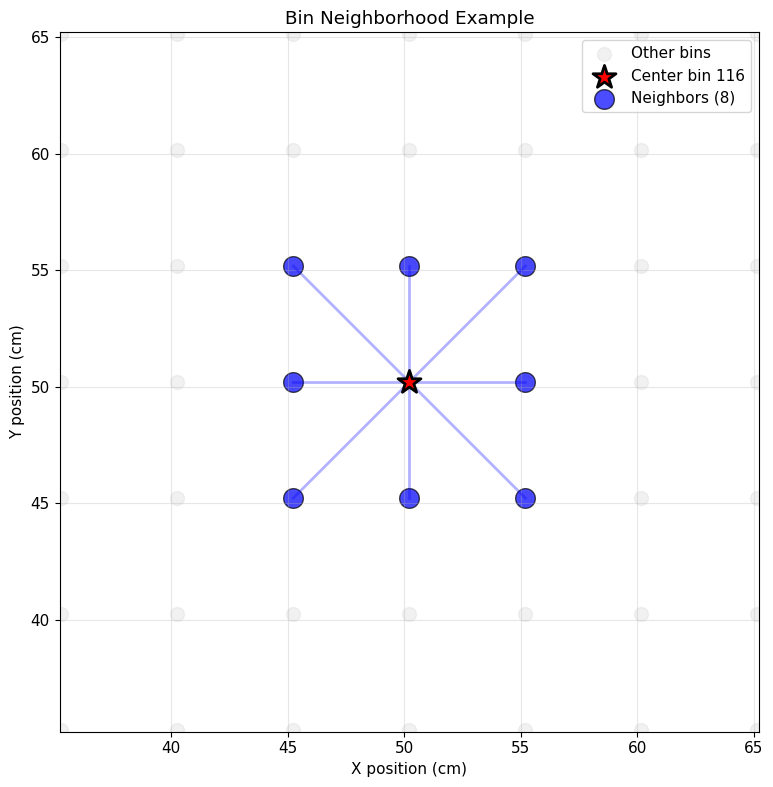

In [29]:
fig, ax = plt.subplots(figsize=(8, 8))

# Plot all bins
ax.scatter(
    env.bin_centers[:, 0],
    env.bin_centers[:, 1],
    c="lightgray",
    s=100,
    alpha=0.3,
    label="Other bins",
)

# Highlight the center bin
ax.scatter(
    env.bin_centers[center_bin, 0],
    env.bin_centers[center_bin, 1],
    c="red",
    s=300,
    marker="*",
    edgecolors="black",
    linewidth=2,
    label=f"Center bin {center_bin}",
    zorder=10,
)

# Highlight neighbors
neighbor_positions = env.bin_centers[neighbor_bins]
ax.scatter(
    neighbor_positions[:, 0],
    neighbor_positions[:, 1],
    c="blue",
    s=200,
    alpha=0.7,
    edgecolors="black",
    linewidth=1,
    label=f"Neighbors ({len(neighbor_bins)})",
)

# Draw edges to neighbors
center_pos = env.bin_centers[center_bin]
for neighbor_pos in neighbor_positions:
    ax.plot(
        [center_pos[0], neighbor_pos[0]],
        [center_pos[1], neighbor_pos[1]],
        "b-",
        alpha=0.3,
        linewidth=2,
    )

ax.set_xlim(center_pos[0] - 15, center_pos[0] + 15)
ax.set_ylim(center_pos[1] - 15, center_pos[1] + 15)
ax.set_xlabel("X position (cm)")
ax.set_ylabel("Y position (cm)")
ax.set_title("Bin Neighborhood Example")
ax.set_aspect("equal")
ax.legend(loc="upper right")
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## The Impact of bin_size

Choosing the right `bin_size` is crucial! Let's compare three different bin sizes to see the trade-offs:

In [30]:
# Create environments with different bin sizes
bin_sizes = [2.5, 5.0, 10.0]  # cm
envs = {}

for bin_size in bin_sizes:
    envs[bin_size] = Environment.from_samples(
        data_samples=position_2d, bin_size=bin_size, name=f"OpenField_{bin_size}cm"
    )
    print(f"\nBin size = {bin_size} cm:")
    print(f"  Total bins: {envs[bin_size].n_bins}")
    print(f"  Grid shape: {envs[bin_size].grid_shape}")


Bin size = 2.5 cm:
  Total bins: 684
  Grid shape: (35, 35)

Bin size = 5.0 cm:
  Total bins: 211
  Grid shape: (18, 18)

Bin size = 10.0 cm:
  Total bins: 75
  Grid shape: (10, 10)


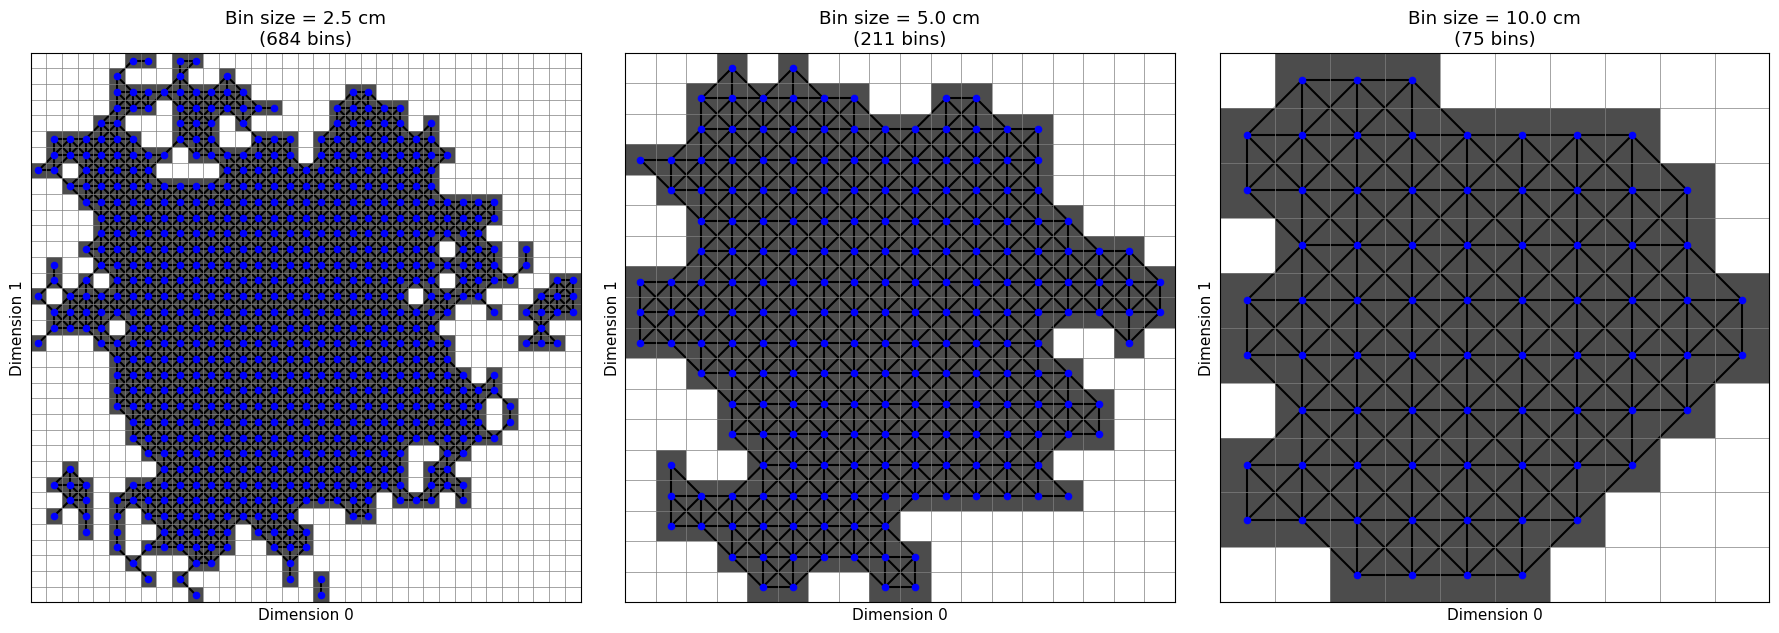

In [31]:
# Visualize the three environments
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for ax, bin_size in zip(axes, bin_sizes, strict=False):
    envs[bin_size].plot(ax=ax, show_connectivity=True)
    ax.set_title(f"Bin size = {bin_size} cm\n({envs[bin_size].n_bins} bins)")

plt.tight_layout()
plt.show()

**What to notice:**
- **2.5 cm bins**: High resolution, but many bins with few samples
- **5 cm bins**: Good balance for most analyses
- **10 cm bins**: Lower resolution, but each bin has more samples

**Rule of thumb:** Choose bin_size so each bin gets at least 10-20 samples for stable estimates.

## Common Pitfalls and How to Avoid Them

### Pitfall 1: bin_size is too large

If bin_size is larger than your environment, you'll get an error:

In [32]:
# This will fail!
try:
    bad_env = Environment.from_samples(
        data_samples=position_2d,
        bin_size=200.0,  # 200 cm - way too large!
        name="TooBig",
    )
except ValueError as e:
    print(f"Error: {e}")
    print("\nSolution: Use a smaller bin_size!")

### Pitfall 2: Unit mismatch

Make sure your `bin_size` units match your data units!

In [33]:
# Example: data in centimeters, but you think it's in meters
# A 0.05 cm bin would be way too small!

print("If your data is in centimeters, use bin_size in centimeters (e.g., 5.0)")
print("If your data is in meters, use bin_size in meters (e.g., 0.05)")
print("If your data is in pixels, use bin_size in pixels (e.g., 10)")

If your data is in centimeters, use bin_size in centimeters (e.g., 5.0)
If your data is in meters, use bin_size in meters (e.g., 0.05)
If your data is in pixels, use bin_size in pixels (e.g., 10)


### Pitfall 3: Not using factory methods

Always use factory methods like `from_samples()`, never call `Environment()` directly:

In [34]:
# ✗ WRONG - Don't do this!
# env = Environment()  # This won't work!

# ✓ CORRECT - Use factory methods
env_correct = Environment.from_samples(data_samples=position_2d, bin_size=5.0)
print("Always use factory methods like from_samples()!")

Always use factory methods like from_samples()!


## Key Takeaways

Congratulations! You now know the basics of neurospatial. Here's what you learned:

1. **Spatial discretization** converts continuous position data into discrete bins for analysis
2. **`Environment.from_samples()`** is the main way to create environments from data
3. **`bin_size`** controls the resolution of your spatial grid (units must match your data)
4. **Active bins** are bins that contain data samples
5. **Core operations:**
   - `bin_at(points)` - Map positions to bin indices
   - `contains(points)` - Check if points are in the environment
   - `neighbors(bin_idx)` - Find adjacent bins
   - `plot()` - Visualize the environment
6. **Choose bin_size wisely** - balance resolution vs samples per bin

## Next Steps

In the next notebook (**02_layout_engines.ipynb**), you'll learn about:
- Different layout engines (hexagonal, polygon-bounded, etc.)
- When to use each layout type
- Comparing connectivity patterns

## Exercises (Optional)

Try these on your own to reinforce your learning:

1. Create an environment with 3 cm bins and compute the occupancy
2. Find the 5 most visited bins and plot them
3. Calculate the percentage of time spent in the center (50±20 cm square)
4. Create environments with different bin sizes and compare the number of active bins